# Simple demo of GroundingDINO + Segment Anything Model

In [1]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T
from torchvision.ops import box_convert
from transformers import AutoTokenizer

import supervision as sv

from openvino.runtime import Core

## GroundingDINO

In [2]:
def load_image(image_path, shape=[512, 512]):
    image_pil = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.Resize(shape),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    image = transform(image_pil)
    return image_pil, image

In [3]:
def load_model(model_checkpoint_path, device):
    core = Core()
    model_read = core.read_model(model_checkpoint_path)
    model = core.compile_model(model_read, device.upper())
    model.tokenizer = AutoTokenizer.from_pretrained('./models/tokenizer_pretrained_pytorch')
    model.max_text_len = 256
    return model

In [4]:
def generate_masks(tokenized, special_tokens_list):
    """Generate attention mask between each pair of special tokens
    Args:
        input_ids (torch.Tensor): input ids. Shape: [bs, num_token]
        special_tokens_mask (list): special tokens mask.
    Returns:
        torch.Tensor: attention mask between each special tokens.
    """
    input_ids = tokenized["input_ids"]
    bs, num_token = input_ids.shape
    # special_tokens_mask: bs, num_token. 1 for special tokens. 0 for normal tokens
    special_tokens_mask = torch.zeros((bs, num_token)).bool()
    for special_token in special_tokens_list:
        special_tokens_mask |= input_ids == special_token

    # idxs: each row is a list of indices of special tokens
    idxs = torch.nonzero(special_tokens_mask)

    # generate attention mask and positional ids
    attention_mask = (torch.eye(num_token).bool().unsqueeze(0).repeat(bs, 1, 1))
    position_ids = torch.zeros((bs, num_token))
    previous_col = 0
    for i in range(idxs.shape[0]):
        row, col = idxs[i]
        if (col == 0) or (col == num_token - 1):
            attention_mask[row, col, col] = True
            position_ids[row, col] = 0
        else:
            attention_mask[row, previous_col + 1 : col + 1, previous_col + 1 : col + 1] = True
            position_ids[row, previous_col + 1 : col + 1] = torch.arange(0, col - previous_col)
        previous_col = col

    return attention_mask, position_ids.to(torch.long)

In [5]:
from typing import Dict

def get_phrases_from_posmap(
            posmap: torch.BoolTensor,
            tokenized: Dict,
            tokenizer: AutoTokenizer,
            left_idx: int = 0, right_idx: int = 255):
    if posmap.dim() == 1:
        posmap[0: left_idx + 1] = False
        posmap[right_idx:] = False
        non_zero_idx = posmap.nonzero(as_tuple=True)[0].tolist()
        token_ids = [tokenized["input_ids"][i] for i in non_zero_idx]
        return tokenizer.decode(token_ids)
    else:
        raise NotImplementedError("posmap must be 1-dim")

In [6]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [7]:
def get_grounding_output(model, image, caption, box_threshold, text_threshold):
    caption = caption.lower().strip()
    if not caption.endswith("."):
        caption = caption + "."

    tokenized = model.tokenizer(caption, padding="longest", return_tensors="pt")
    specical_tokens = model.tokenizer.convert_tokens_to_ids(["[CLS]", "[SEP]", ".", "?"])
    
    text_self_attention_masks, position_ids = generate_masks(tokenized, specical_tokens)

    if text_self_attention_masks.shape[1] > model.max_text_len:
        text_self_attention_masks = text_self_attention_masks[
            :, : model.max_text_len, : model.max_text_len]
        
        position_ids = position_ids[:, : model.max_text_len]
        tokenized["input_ids"] = tokenized["input_ids"][:, : model.max_text_len]
        tokenized["attention_mask"] = tokenized["attention_mask"][:, : model.max_text_len]
        tokenized["token_type_ids"] = tokenized["token_type_ids"][:, : model.max_text_len]

    inputs = {}
    input_img = np.expand_dims(image, 0)
    inputs["img"] = input_img
    inputs["input_ids"] = tokenized["input_ids"]
    inputs["attention_mask"] = tokenized["attention_mask"]
    inputs["token_type_ids"] = tokenized["token_type_ids"]
    inputs["position_ids"] = position_ids
    inputs["text_token_mask"] = text_self_attention_masks 

    outputs = model.infer_new_request(inputs)

    prediction_logits_ = sigmoid(np.squeeze(outputs["logits"], 0)) # prediction_logits.shape = (nq, 256)
    prediction_boxes_ = np.squeeze(outputs["boxes"], 0) # prediction_boxes.shape = (nq, 4)
    logits = torch.from_numpy(prediction_logits_)
    boxes = torch.from_numpy(prediction_boxes_)

    # filter output
    mask = logits.max(dim=1)[0] > box_threshold
    logits = logits[mask]  # num_filt, 256
    boxes = boxes[mask]  # num_filt, 4

    # get phrase
    tokenized = model.tokenizer(caption)
    phrases = [get_phrases_from_posmap(logit > text_threshold, tokenized, model.tokenizer) for logit in logits]

    return boxes, logits.max(dim=1)[0], phrases

In [8]:
image_path = 'assets/cat_dog.jpeg'
image_shape = [512, 512]
image_pil, image = load_image(image_path, image_shape)


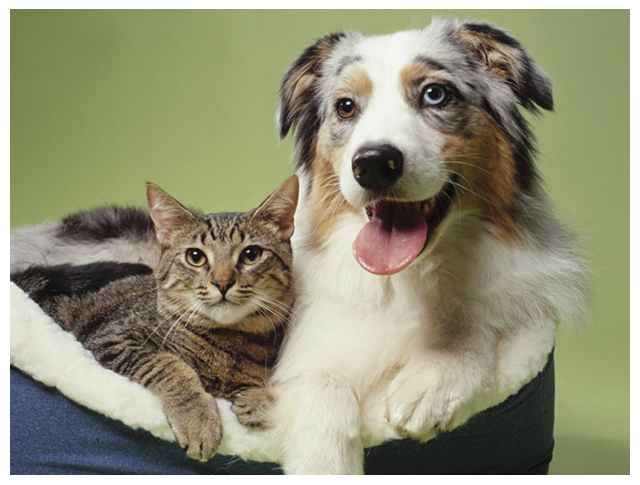

In [9]:
plt.figure(figsize=(8,8))
plt.imshow(np.array(image_pil))
plt.axis('off')
plt.show()

In [10]:
text_prompt = "the cat and the dog."
box_threshold = 0.4
text_threshold = 0.25

In [11]:
model = load_model('./models/groundingdino_512.xml', 'GPU')

In [12]:
boxes, logits, phrases = get_grounding_output(model, image, text_prompt, box_threshold, text_threshold)

/tmp/ipykernel_164922/3886325312.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


In [14]:
from typing import List

def find_index(string, lst):
    # if meet string like "lake river" will only keep "lake"
    # this is an hack implementation for visualization which will be updated in the future
    string = string.lower().split()[0]
    for i, s in enumerate(lst):
        if string in s.lower():
            return i
    return 0

def phrases2classes(phrases: List[str], classes: List[str]) -> np.ndarray:
    class_ids = []
    for phrase in phrases:
        try:
            class_ids.append(find_index(phrase, classes))
        except ValueError:
            class_ids.append(None)
    return np.array(class_ids)

In [16]:
classes = ["cat", "dog"]

In [13]:
def post_process_result(
        source_h: int,
        source_w: int,
        boxes: torch.Tensor,
        logits: torch.Tensor
) -> sv.Detections:
    boxes = boxes * torch.Tensor([source_w, source_h, source_w, source_h])
    xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    confidence = logits.numpy()
    class_ids = phrases2classes(phrases, classes)
    return sv.Detections(xyxy=xyxy, confidence=confidence, class_id = class_ids)

In [17]:
sw, sh = image_pil.size
detections = post_process_result(source_h=sh, source_w=sw, boxes=boxes, logits=logits)

In [18]:
img = np.array(image_pil) # to cv2 format

In [19]:
box_annotator = sv.BoxAnnotator()
box_annotator.text_scale=0.5
box_annotator.text_padding=0

In [20]:
#mask_annotator = sv.MaskAnnotator()
labels = [f"{p} {c:.2f}" for p, c in zip(phrases, detections.confidence.tolist())]
#annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=img.copy(), detections=detections, labels=labels)

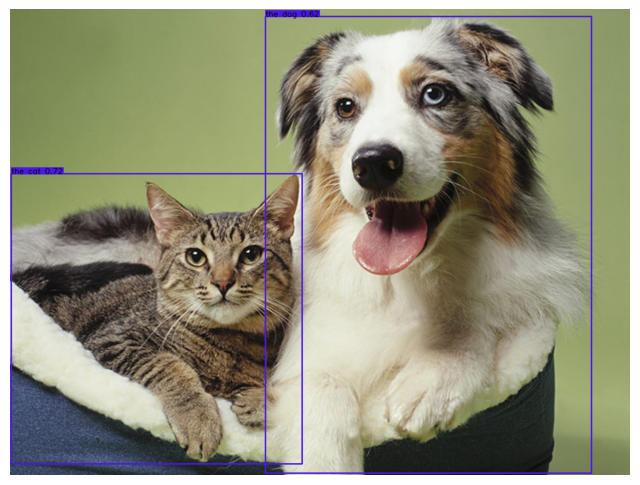

In [21]:
plt.figure(figsize=(8,8))
plt.imshow(annotated_image)
plt.axis('off')
plt.show()

## Segment Anything Model

In [22]:
device = 'GPU'
model_type = 'vit_h'

In [23]:
core = Core()
sam_encoder_path = Path(f'./models/sam/sam_image_encoder_{model_type}.xml')
sam_predict_path = Path(f'./models/sam/sam_mask_predictor_{model_type}.xml')
sam_encoder_model = core.read_model(sam_encoder_path)
sam_predict_model = core.read_model(sam_predict_path)
sam_encoder = core.compile_model(sam_encoder_model, device)
sam_predict = core.compile_model(sam_predict_model, device)

In [24]:
from copy import deepcopy
from typing import Tuple
from torchvision.transforms.functional import resize, to_pil_image

class ResizeLongestSide:
    """
    Resizes images to longest side 'target_length', as well as provides
    methods for resizing coordinates and boxes. Provides methods for
    transforming numpy arrays.
    """

    def __init__(self, target_length: int) -> None:
        self.target_length = target_length

    def apply_image(self, image: np.ndarray) -> np.ndarray:
        """
        Expects a numpy array with shape HxWxC in uint8 format.
        """
        target_size = self.get_preprocess_shape(image.shape[0], image.shape[1], self.target_length)
        return np.array(resize(to_pil_image(image), target_size))

    def apply_coords(self, coords: np.ndarray, original_size: Tuple[int, ...]) -> np.ndarray:
        """
        Expects a numpy array of length 2 in the final dimension. Requires the
        original image size in (H, W) format.
        """
        old_h, old_w = original_size
        new_h, new_w = self.get_preprocess_shape(
            original_size[0], original_size[1], self.target_length
        )
        coords = deepcopy(coords).astype(float)
        coords[..., 0] = coords[..., 0] * (new_w / old_w)
        coords[..., 1] = coords[..., 1] * (new_h / old_h)
        return coords

    def apply_boxes(self, boxes: np.ndarray, original_size: Tuple[int, ...]) -> np.ndarray:
        """
        Expects a numpy array shape Bx4. Requires the original image size
        in (H, W) format.
        """
        boxes = self.apply_coords(boxes.reshape(-1, 2, 2), original_size)
        return boxes.reshape(-1, 4)

    @staticmethod
    def get_preprocess_shape(oldh: int, oldw: int, long_side_length: int) -> Tuple[int, int]:
        """
        Compute the output size given input size and target long side length.
        """
        scale = long_side_length * 1.0 / max(oldh, oldw)
        newh, neww = oldh * scale, oldw * scale
        neww = int(neww + 0.5)
        newh = int(newh + 0.5)
        return (newh, neww)

resizer = ResizeLongestSide(1024)

In [25]:
def preprocess_image(image: np.ndarray):
    resized_image = resizer.apply_image(image)
    resized_image = (resized_image.astype(np.float32) - [123.675, 116.28, 103.53]) / [58.395, 57.12, 57.375]
    resized_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)).astype(np.float32), 0)

    # Pad
    h, w = resized_image.shape[-2:]
    padh = 1024 - h
    padw = 1024 - w
    x = np.pad(resized_image, ((0, 0), (0, 0), (0, padh), (0, padw)))
    return x

In [26]:
from torch.nn.functional import interpolate
def postprocess_masks(masks: np.ndarray, orig_size):
    size_before_pad = resizer.get_preprocess_shape(orig_size[0], orig_size[1], masks.shape[-1])
    masks = masks[..., :int(size_before_pad[0]), :int(size_before_pad[1])]
    masks = interpolate(torch.from_numpy(masks), size=orig_size, mode="bilinear", align_corners=False).numpy()
    return masks

In [28]:
import cv2
#image_pil, image = load_image(image_path, [1024, 1024])
image = cv2.imread('GroundingDINO/.asset/cat_dog.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
preprocessed_image = preprocess_image(image)
encoding_results = sam_encoder(preprocessed_image)
image_embeddings = encoding_results[sam_encoder.output(0)]

In [29]:
masks = []
for box in detections.xyxy:
    coord = box.reshape(2,2)[None, :, :]
    label = np.array([2,3])[None, :].astype(np.float32)
    coord = resizer.apply_coords(coord, image.shape[:2])#.astype(np.float32)

    inputs = {
        "image_embeddings": image_embeddings,
        "point_coords": coord,
        "point_labels": label,
    }
    results = sam_predict(inputs)

    mask = results[sam_predict.output(0)]
    mask = postprocess_masks(mask, image.shape[:-1])
    mask = mask > 0.0
    masks.append(mask)

In [31]:
#box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
annotated_image = image.copy()
for mask in masks:
    detections.mask = mask[0]
    annotated_image = mask_annotator.annotate(scene=annotated_image, detections=detections)
labels = [f"{p} {c:.2f}" for p, c in zip(phrases, detections.confidence.tolist())]
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)


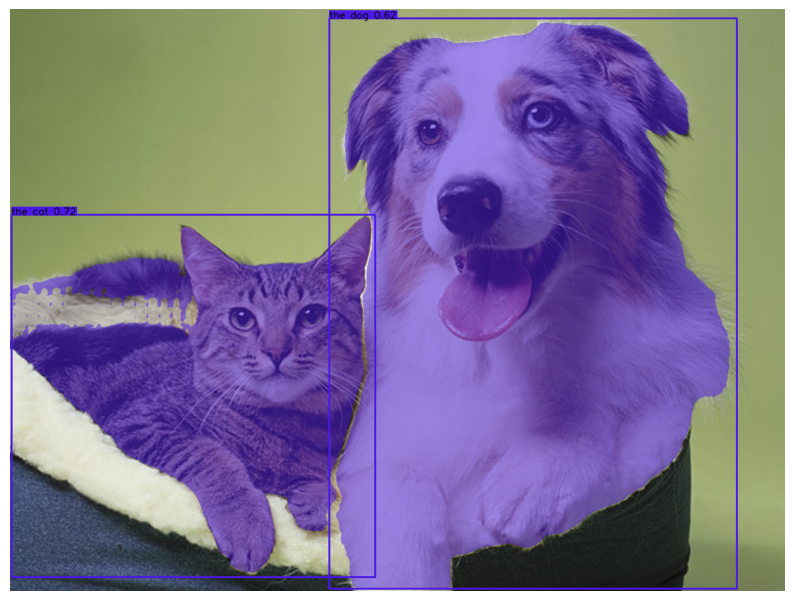

In [32]:
plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.axis('off')
plt.show()